In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, Flatten

In [2]:
news_data = pd.read_pickle(r"./Datasets/data/financial_headlines_20061020-20131119.pkl")
df = pd.DataFrame(news_data)
df.set_index('date',inplace=True)
financial_data = pd.read_pickle(r"./Datasets/data/stock_data.pkl")
oneyearrate = financial_data['1 YEAR']

In [3]:
start_date = datetime(2006,10,20)
end_date = datetime(2013,1,1)
titles = df.loc[start_date.strftime("%Y-%m-%d") : end_date.strftime("%Y-%m-%d")]

In [20]:
def concat_news(news,period):
    """Merges news headlines over a period of days as one single list of words,
    tokenized by word_tokenize() in nltk. 
    
    Parameters: 
    news (DataFrame): News data of headlines (str) indexed by datetime.   
    period (int): Number of days in each period. 
    
    Returns: 
    DataFrame of lists of words indexed by datetime.
    """
    delta = timedelta(days=period)
    t1 = news.index[0]
    t2 = t1 + delta
    end_date = news.index[-1]
    data = pd.DataFrame({'titles': [], 'date': []})
    while(t2 < end_date):
        period_words = []
        titles = list([word_tokenize(title) for title in news.loc[t1.strftime("%Y-%m-%d") : t2.strftime("%Y-%m-%d")]['title']])
        for title in titles: 
            for word in title: 
                period_words.append(word)
        data = data.append({'date': t1, 'titles': period_words},ignore_index=True)
        t1 = t2
        t2 = t2 + delta    
    titles = list([word_tokenize(t) for t in news.loc[t1.strftime("%Y-%m-%d") : end_date.strftime("%Y-%m-%d")]['title']])
    for title in titles: 
            for word in title: 
                period_words.append(word)
    data = data.append({'date': t1, 'titles': period_words},ignore_index=True)
    data.set_index('date',inplace=True)
    return data
    
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True: 
        if shuffle: 
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index: 
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                       lookback,
                       data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
    
def add_rate_data(x_words,x_rates,indices):
    """Add time-series data of the rate/returns to a data point which
    containes some vectorized version of words.
    
    Parameters: 
    A numpy array x_words representing the words with shape n*d and a numpy array 
    x_rates of prices/rates with shape n. 
    
    Returns: 
    A numpy array of shape n*(d+1) 
    """
    temp = np.zeros((x_words.shape[0], x_words.shape[1]+1))
    temp[:,:-1] = x_words
    temp[:,-1] = np.array([x_rates[d] for d in indices])
    return temp

def plot_history(history,train=True,val=True,log=True):
    if train: 
        plt.plot(history.history['loss'],label="Train")
    if val:
        plt.plot(history.history['val_loss'],label="Val")
    plt.legend()
    if log : plt.yscale('log')
    plt.show()
    

In [5]:
# Aggregate the headlines into blocks of 7 days. 
concated_news = concat_news(titles,7)

In [29]:
# Tokenize the data using tf-idf from Keras and split into train/test
max_words = 1000                # Include the max_words most common words. 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(concated_news['titles'])
x = tokenizer.texts_to_matrix(concated_news['titles'],mode='tfidf')
# Add a column with the days numeric data
x = add_rate_data(x,oneyearrate,concated_news.index)
n,d = x.shape
test_fraction = 0.1       # Use 10 % as test data.
x_train = x[:round(len(x)*(1 - test_fraction))]
x_test = x[round(len(x)*(1 - test_fraction)):]

# Construct the labels as the US treasury rate 3 months ahead of time. 
delta = timedelta(weeks=12)
y_train = np.zeros(len(x_train))
y_test = np.zeros(len(x_test))
for index, entry in enumerate(concated_news.index):
    if index < len(y_train): 
        y_train[index] = oneyearrate.loc[entry + delta]
    else: 
        y_test[index - len(y_train)] = oneyearrate.loc[entry + delta]
    

In [34]:
# Create an ordinary feed-forward model 
m_ff = Sequential()
m_ff.add(Flatten(input_shape=(lookback,x.shape[-1])))
m_ff.add(Dense(32,activation='relu'))
m_ff.add(Dense(1))
m_ff.add(Activation('linear'))

#m_ff.add(Dense(512, input_shape = (max_words,)))
#m_ff.add(Dropout(0.5))
#m_ff.add(Activation('relu'))
#m_ff.add(Dense(10))
#m_ff.add(Dropout(0.5))
#m_ff.add(Dense(1))
#m_ff.add(Activation('linear'))
m_ff.compile(loss='MSE',optimizer='adam')
m_ff.summary()
batch_size = 32
epochs = 100

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3003)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                96128     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 96,161
Trainable params: 96,161
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Create a simple RNN-model with GRU
m_gru = Sequential() 
m_gru.add(GRU(32,
              dropout=0.2,
              recurrent_dropout=0.2,
              input_shape=(None, x.shape[-1])))
m_gru.add(Dense(1))

m_gru.compile(optimizer='adam', loss='mse')

In [25]:
# Create generators 
train_split = 0.6
val_split = 0.2
test_split = 0.2
lookback=3
delay=4
batch_size=10
train_gen = generator(data=x,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(train_split*n),
                      shuffle=True,
                      batch_size=batch_size
)

val_gen = generator(data=x,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(train_split*n) + 1,
                    max_index=round(train_split*n) + round(val_split*n),
                    batch_size=batch_size
)

test_gen = generator(data=x,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(train_split*n) + round(val_split*n) + 1,
                     max_index=None,
                    batch_size=batch_size
)

val_steps = (round(val_split*n) - 1 - lookback) // batch_size

test_steps = (n - round(train_split*n) - round(val_split*n) - 1 - lookback) // batch_size

In [35]:
# Fit feed-forward model 
ff_history = m_ff.fit_generator(train_gen,
                               steps_per_epoch=10,
                               epochs=50,
                               validation_data=val_gen,
                               validation_steps=val_steps)

Epoch 1/50
10/10 [==============================] - 0s 25ms/step - loss: 9.0075 - val_loss: 4.2306
Epoch 2/50
10/10 [==============================] - 0s 22ms/step - loss: 1.2702 - val_loss: 0.3787
Epoch 3/50
10/10 [==============================] - 0s 23ms/step - loss: 0.3113 - val_loss: 0.3190
Epoch 4/50
10/10 [==============================] - 0s 23ms/step - loss: 0.2868 - val_loss: 0.3346
Epoch 5/50
10/10 [==============================] - 0s 24ms/step - loss: 0.2650 - val_loss: 0.2781
Epoch 6/50
10/10 [==============================] - 0s 23ms/step - loss: 0.2578 - val_loss: 0.2756
Epoch 7/50
10/10 [==============================] - 0s 22ms/step - loss: 0.1855 - val_loss: 0.2586
Epoch 8/50
10/10 [==============================] - 0s 23ms/step - loss: 0.1993 - val_loss: 0.2508
Epoch 9/50
10/10 [==============================] - 0s 22ms/step - loss: 0.1368 - val_loss: 0.2251
Epoch 10/50
10/10 [==============================] - 0s 23ms/step - loss: 0.1238 - val_loss: 0.2094
Epoch 11/

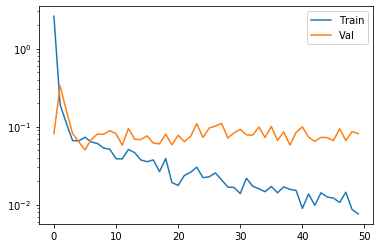

In [27]:
# Fit GRU-model  
gru_history = m_gru.fit_generator(train_gen,
                                 steps_per_epoch=10,
                                 epochs=50,
                                 validation_data=val_gen,
                                 validation_steps=val_steps)
plot_history(gru_history,log=True)

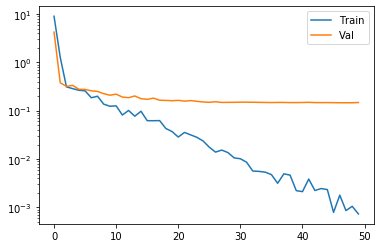

In [36]:
plot_history(ff_history,log=True)

In [ ]:
history = model.fit_generator(gen,steps_per_epoch=5,epochs=1,verbose=1)

In [ ]:
score = model.evaluate(x_test,y_test,batch_size=batch_size,verbose=0)
plt.plot(history.history['loss'],label="Training Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.yscale("log")
plt.legend()
print("Evaluation test score: {}".format(round(score,5)))

In [ ]:
preds_train = [model.predict(np.array([xi]))[0] for xi in x_train]

In [ ]:
preds_test = [model.predict(np.array([xi]))[0] for xi in x_test]
plt.close()
plt.plot(preds_train,label="Pred")
plt.plot(y_train,label="Values")
plt.legend()
plt.show()
plt.plot(preds_test,label="Pred")
plt.plot(y_test,label="Values")
plt.legend()
plt.show()

In [ ]:
gen = generator(data=concated_news,lookback=3,delay=4,min_index=0,max_index=250)
model.fit_generator(gen,steps_per_epoch=5,epochs=1,verbose=1)